In [ ]:
import pandas as pd
from datetime import time
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

In [ ]:
df_2018 = pd.read_csv("filtered_taxi_data_2018_cleaned.csv")
df_2019 = pd.read_csv("filtered_taxi_data_2019_cleaned.csv")
df_2020 = pd.read_csv("filtered_taxi_data_2020_cleaned.csv")
df_2021 = pd.read_csv("filtered_taxi_data_2021_cleaned.csv")
df_2022 = pd.read_csv("filtered_taxi_data_2022_cleaned.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'filtered_taxi_data_2018_cleaned.csv'

In [ ]:
df_2018["year"] = 2018
df_2019["year"] = 2019
df_2020["year"] = 2020
df_2021["year"] = 2021
df_2022["year"] = 2022

df = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [ ]:
print("DataFrame Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nFirst 5 rows:")
print(df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275188625 entries, 0 to 275188624
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   VendorID            int64  
 1   passenger_count     float64
 2   trip_distance       float64
 3   RatecodeID          int64  
 4   store_and_fwd_flag  object 
 5   PULocationID        int64  
 6   DOLocationID        int64  
 7   fare_amount         float64
 8   total_amount        float64
 9   total_driving_time  float64
 10  month               int64  
 11  hour                int64  
 12  year                int64  
 13  day                 int64  
 14  weekday             int64  
dtypes: float64(5), int64(9), object(1)
memory usage: 30.8+ GB
None

Summary Statistics:
           VendorID  passenger_count  trip_distance    RatecodeID  \
count  2.751886e+08     2.751886e+08   2.751886e+08  2.751886e+08   
mean   1.642128e+00     1.532614e+00   3.057693e+00  1.086418e+00   
std    4.9

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')

invalid_rows = df[df['date'].isna()]
print("Rows with invalid date values:")
print(invalid_rows[['year', 'month', 'day']])

Rows with invalid date values:
           year  month  day
160635784  2019      2   29
160635785  2019      2   29
160635786  2019      2   29
175128904  2019      2   29
175140519  2019      2   29
179887000  2019      2   29


In [ ]:
df = df[~((df['year'] == 2019) & (df['month'] == 2) & (df['day'] == 29))]

invalid_rows = df[(df['year'] == 2019) & (df['month'] == 2) & (df['day'] == 29)]
print("Rows with invalid date values after removal:")
print(invalid_rows)

Rows with invalid date values after removal:
Empty DataFrame
Columns: [VendorID, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, fare_amount, total_amount, total_driving_time, month, hour, year, day, weekday, date]
Index: []


In [ ]:
print(df[['year', 'month', 'day', 'date']].head())

   year  month  day       date
0  2018      1    1 2018-01-01
1  2018      1    1 2018-01-01
2  2018      1    1 2018-01-01
3  2018      1    1 2018-01-01
4  2018      1    1 2018-01-01


In [ ]:
monthly_summary = df.groupby(pd.Grouper(key='date', freq='M')).agg({
    'fare_amount': 'mean',
    'total_amount': 'mean',
    'trip_distance': 'sum',
    'total_driving_time': 'mean',
    'VendorID': 'count'
}).rename(columns={'VendorID': 'total_rides'})

monthly_summary = monthly_summary.reset_index()

print("\nMonthly Summary Sample:")
print(monthly_summary.head())


Monthly Summary Sample:
        date  fare_amount  total_amount  trip_distance  total_driving_time  \
0 2018-01-31    12.190656     15.430763    24555971.67           15.738630   
1 2018-02-28    12.172298     15.425107    23516970.61           15.827891   
2 2018-03-31    12.606411     15.909752    27003194.59           16.654075   
3 2018-04-30    12.894761     16.248261    27299427.15           17.136743   
4 2018-05-31    13.313940     16.730281    27788777.14           17.794419   

   total_rides  
0      8701334  
1      8436291  
2      9363726  
3      9242695  
4      9159755  


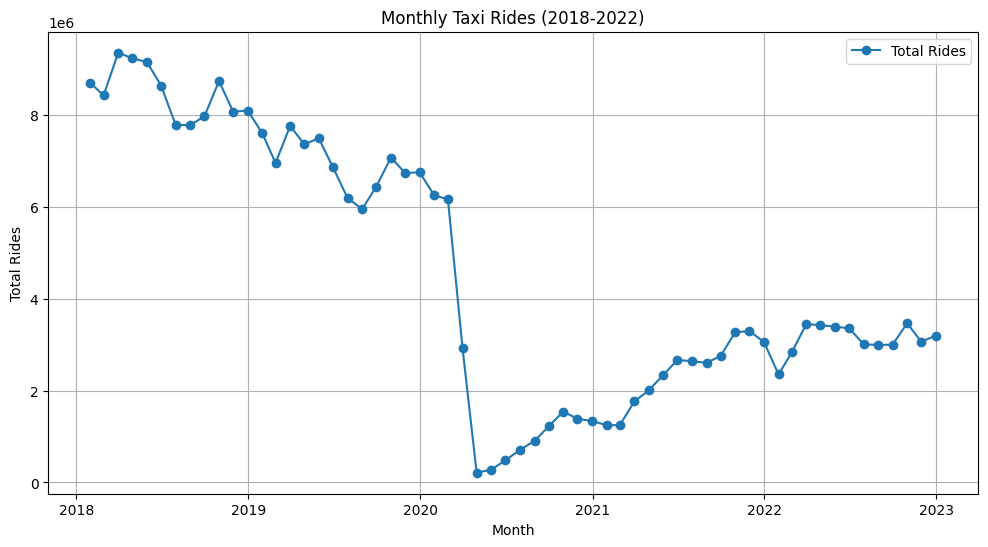

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_summary['date'], monthly_summary['total_rides'], marker='o', label='Total Rides')
plt.xlabel("Month")
plt.ylabel("Total Rides")
plt.title("Monthly Taxi Rides (2018-2022)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
covid_cutoff = pd.Timestamp("2020-03-01")

pre_covid = monthly_summary[monthly_summary['date'] < covid_cutoff]
post_covid = monthly_summary[monthly_summary['date'] >= covid_cutoff]

pre_covid_rides = pre_covid.set_index('date')['total_rides']

print("Pre-COVID Data:")
print(pre_covid_rides.head())

Pre-COVID Data:
date
2018-01-31    8701334
2018-02-28    8436291
2018-03-31    9363726
2018-04-30    9242695
2018-05-31    9159755
Name: total_rides, dtype: int64


In [ ]:
model = sm.tsa.statespace.SARIMAX(
    pre_covid_rides,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        total_rides   No. Observations:                   26
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Thu, 10 Apr 2025   AIC                             10.000
Time:                                    00:54:53   BIC                                nan
Sample:                                01-31-2018   HQIC                               nan
                                     - 02-29-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5652         -0        inf      0.000      -0.565      -0.565
ma.L1         -0.3783         -0   

c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_mode

In [ ]:
n_steps = len(post_covid)

forecast = model_fit.get_forecast(steps=n_steps)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print("Forecasted values:")
print(forecast_mean.head())

Forecasted values:
2020-03-31    6.434215e+06
2020-04-30    6.344990e+06
2020-05-31    6.296626e+06
2020-06-30    5.762492e+06
2020-07-31    5.038970e+06
Freq: M, Name: predicted_mean, dtype: float64


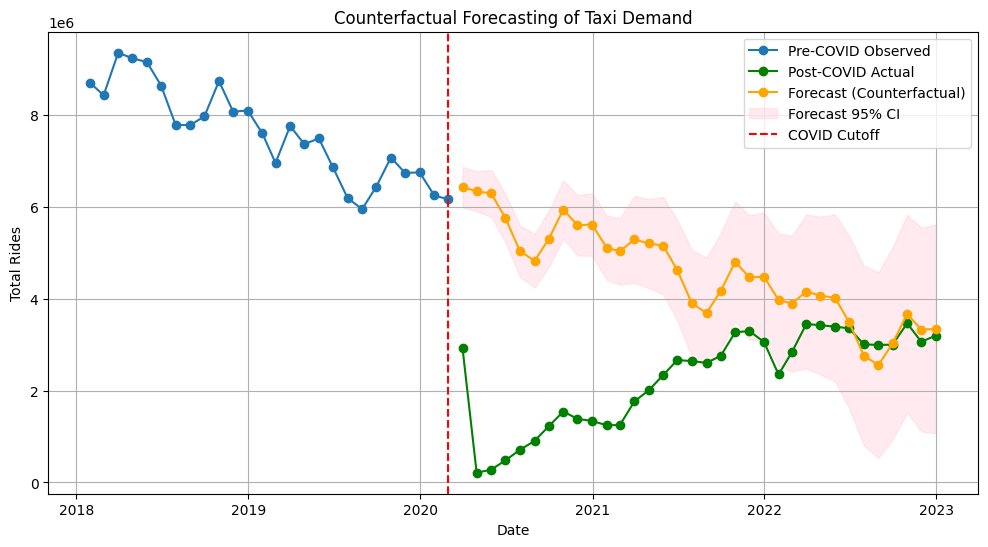

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(pre_covid_rides.index, pre_covid_rides, marker='o', label='Pre-COVID Observed')

plt.plot(post_covid['date'], post_covid['total_rides'], marker='o', label='Post-COVID Actual', color='green')

plt.plot(post_covid['date'], forecast_mean, marker='o', label='Forecast (Counterfactual)', color='orange')

plt.fill_between(
    post_covid['date'],
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Forecast 95% CI'
)

plt.axvline(covid_cutoff, color='red', linestyle='--', label='COVID Cutoff')

plt.xlabel('Date')
plt.ylabel('Total Rides')
plt.title('Counterfactual Forecasting of Taxi Demand')
plt.legend()
plt.grid(True)
plt.show()

The blue line shows a gradual decline in taxi demand prior to the COVID cutoff (red dashed line) in early 2020. Post-COVID actual demand (green) drops sharply and remains below the counterfactual forecast (orange) for much of 2020–2021. The pink band around the orange line represents the 95% confidence interval, highlighting uncertainty but still indicating higher demand would have been likely without the pandemic. A partial recovery is evident starting in 2021, yet remains below the forecast for most of the period. Overall, the chart underscores a substantial and lasting impact of COVID-19 on taxi ridership compared to expected levels.

In [ ]:
difference = forecast_mean - post_covid['total_rides'].values

average_impact = np.mean(difference)
cumulative_impact = np.sum(difference)

print("Average difference (forecast - actual) during post-COVID:", average_impact)
print("Cumulative difference during post-COVID:", cumulative_impact)

Average difference (forecast - actual) during post-COVID: 2293338.3389751627
Cumulative difference during post-COVID: 77973503.52515553


The average monthly shortfall of taxi rides in the post-COVID period was approximately 2.29 million compared to what would have been expected based on pre-COVID trends. Over the entire post-COVID period, this accumulates to nearly 78 million fewer rides, indicating a substantial and lasting disruption in taxi demand. This counterfactual analysis underscores the significant impact COVID-19 had on taxi usage relative to normal conditions.